In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tools import PDF

# On importe la métrique "silhouette" qui nous servira à déterminer le nombre de clusters optimal.
from sklearn.metrics import silhouette_score 

pdf = PDF('output/clustering/')

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv')

In [3]:
len(df)

1610494

In [4]:
 df_clusters = df[['contextid','dayssincelastvisitdouble','campaignctrlast24h','nbdisplay_1hour','nbdayssincelastclick','display_size','ltf_nbpartnerdisplayssincelastclick','ltf_nbglobaldisplay_4w','ltf_nbpartnerclick_90d','ltf_nbpartnerdisplay_90d','ltf_nbpartnersales_90d','nbdisplayglobalapprox_1d_sum_xdevice','zonecostineuro']]

In [5]:
# On va chercher à obtenir des groupes d'observations de caractéristiques proches afin de voir si l'on peut distinguer les clics des non-clics. 
sc = StandardScaler()
Z = sc.fit_transform(df_clusters)
Z

array([[ 0.14873565, -0.40809959, -0.8906595 , ..., -0.01397608,
        -0.32103262, -0.25119805],
       [-1.92104218, -0.44867976, -0.360678  , ..., -0.01397608,
         0.8070464 , -0.36603538],
       [ 0.14873565, -0.33748309,  1.82717896, ..., -0.01397608,
        -0.5009203 , -0.27723314],
       ...,
       [ 0.97664678, -0.36785013, -0.92834265, ..., -0.01397608,
        -0.51352702,  1.57702331],
       [ 1.39060235, -0.4168148 ,  2.20278178, ..., -0.01397608,
        -0.34134216, -0.36790665],
       [ 0.14873565, -0.1664472 , -0.50158415, ..., -0.01397608,
        -0.45594838, -0.19116658]])

In [6]:
# Vérification que les moyennes sont nulles et les écarts-types unitaires. 
print(np.mean(Z, axis=0))
print(np.std(Z, axis=0, ddof=0))

[-4.69520271e-17  2.43107555e-16 -7.53163105e-15 -2.04450003e-17
 -9.95337090e-18  1.23711223e-17  1.66154232e-17 -1.56712648e-17
  9.90263342e-18  4.87962244e-18 -2.46683444e-18 -3.14740059e-16
 -1.35711742e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
# On fixe une graine aléatoire pour avoir des résultats reproductibles
GRAINE = 127725252

In [8]:
%%time
# On va faire varier le nombre de clusters dans un intervalle réaliste, disons de 2 à 10.
range_clusters = np.arange(2, 11)
res = []
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=GRAINE)
    kmeans.fit(Z)
    res.append(silhouette_score(Z, kmeans.labels_, n_jobs=-1, sample_size=25000, random_state=GRAINE))
    print(f"Nb clusters : {k} ; score silhouette : {res[-1]:.4f}.")
# print(res)

Nb clusters : 2 ; score silhouette : 0.8811.
Nb clusters : 3 ; score silhouette : 0.2862.
Nb clusters : 4 ; score silhouette : 0.2653.
Nb clusters : 5 ; score silhouette : 0.2664.
Nb clusters : 6 ; score silhouette : 0.1826.
Nb clusters : 7 ; score silhouette : 0.1953.
Nb clusters : 8 ; score silhouette : 0.2207.
Nb clusters : 9 ; score silhouette : 0.2218.
Nb clusters : 10 ; score silhouette : 0.2390.
CPU times: user 49min 27s, sys: 1h 10min 24s, total: 1h 59min 51s
Wall time: 7min 13s


Export PDF : output/clustering/00.pdf



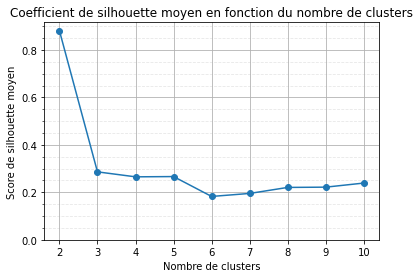

In [9]:
fig, ax = plt.subplots()
plt.plot(range_clusters, res, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette moyen")
plt.ylim(ymin=0)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major')
ax.grid(b=True, which='minor', axis='y', linestyle='--', alpha=0.3)
pdf.export()
plt.title("Coefficient de silhouette moyen en fonction du nombre de clusters")
plt.show()

In [10]:
%%time
# On applique la méthode des k-means sur les variables centrées et réduites, pour 2 clusters d'après la figure précédente.
kmeans = KMeans(n_clusters=2, random_state=GRAINE) 
# random_state est la graine aléatoire specifiée pour rendre les résultats reproductibles.
kmeans.fit(Z)

# On trie les index en fonction des différents groupes de députés (ie des clusters).
idk = np.argsort(kmeans.labels_)

# Affichage des observations et de leurs groupes.
print(pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]}))

         Observation  Cluster
0                  0        0
1            1072674        0
2            1072673        0
3            1072672        0
4            1072671        0
...              ...      ...
1610489       282184        1
1610490      1250993        1
1610491      1250995        1
1610492      1451250        1
1610493       153158        1

[1610494 rows x 2 columns]
CPU times: user 2min 36s, sys: 58.9 s, total: 3min 35s
Wall time: 14.5 s


In [11]:
nb_clusters = kmeans.labels_.tolist()
print(nb_clusters.count(0)) # Comptage du nombre d'observations dans le cluster 1.
print(nb_clusters.count(1)) # Comptage du nombre d'observations dans le cluster 2.

1604441
6053


Etudions les caractéristiques des observations dans chacun des clusters. 

In [12]:
A = pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]})
L1 = [] # Liste qui contiendra les index des observations du cluster 1.
L2 = [] # Liste qui contiendra les index des observations du cluster 2.
for i in range(len(A)) :
    if A['Cluster'][i] == 0 :
        L1.append(A['Observation'][i])
    if A['Cluster'][i] == 1 :
        L2.append(A['Observation'][i])

In [13]:
df_cluster_1 = df.loc[L1] # Sous-table avec les députés du cluster 1.
df_cluster_2 = df.loc[L2] # Sous-table avec les députés du cluster 2.

In [14]:
len(L1), len(L2)

(1604441, 6053)

On retrouve bien le nombre d'observations présentes dans chaque cluster. 

In [15]:
# Répartition des clics et des non clics dans le cluster 1.
display(pd.DataFrame({'Nb dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 2.
display(pd.DataFrame({'Nb dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(normalize=True)})) 

,Nb dans cluster 1,Prop dans cluster 1
0,1513136,0.943092
1,91305,0.056908


,Nb dans cluster 2,Prop dans cluster 2
0,5606,0.926152
1,447,0.073848


In [16]:
df_cluster_1.describe()

,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,googlepagevertical,...,nbdayssincelastclick,nbdisplay_1hour,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,is_display_clicked,zonecostineuro,display_size,hour
count,1.604441e+06,1.604441e+06,1.597547e+06,1.597547e+06,1.597547e+06,1.454152e+06,1.454152e+06,1.454152e+06,499791.000000,1597547.0,...,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06,1.604441e+06
mean,5.634175e+00,1.104855e+00,3.663098e+01,7.278678e-01,9.465114e+01,9.932453e+07,-8.752976e+07,-1.201327e+08,59.246695,-1.0,...,2.039503e+01,4.898621e+00,1.437696e+01,1.778539e+01,4.426991e+01,2.619075e-01,5.690767e-02,1.109745e+00,8.250882e+04,1.388083e+01
std,2.415276e+00,3.063661e-01,3.344792e+01,8.059941e-01,9.919583e+02,1.254868e+09,1.153434e+09,1.171172e+09,31.070997,0.0,...,4.551057e+01,8.463490e+00,1.733519e+01,4.213285e+01,6.650553e+01,1.857041e-01,2.316662e-01,2.963095e+00,9.718136e+04,5.137996e+00
min,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,-1.000000e+00,-2.147479e+09,-2.147454e+09,-2.147479e+09,-1.000000,-1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.411759e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.200000e+01,-9.531958e+08,-1.033737e+09,-1.044180e+09,36.000000,-1.0,...,0.000000e+00,0.000000e+00,1.584028e+00,2.393519e-01,8.000000e+00,1.142579e-01,0.000000e+00,7.100000e-02,4.000000e+00,1.000000e+01
50%,6.000000e+00,1.000000e+00,2.900000e+01,1.000000e+00,1.600000e+01,2.603107e+08,-6.162982e+07,-3.225585e+08,66.000000,-1.0,...,1.000000e+00,1.000000e+00,7.000000e+00,4.000000e+00,2.300000e+01,1.889853e-01,0.000000e+00,3.090000e-01,7.500000e+04,1.400000e+01
75%,7.000000e+00,1.000000e+00,7.300000e+01,1.000000e+00,1.270000e+02,1.384186e+09,7.889378e+08,7.657979e+08,85.000000,-1.0,...,1.700000e+01,6.000000e+00,2.150986e+01,1.677037e+01,5.445278e+01,5.000993e-01,0.000000e+00,9.600000e-01,1.080000e+05,1.800000e+01
max,9.000000e+00,2.000000e+00,1.340000e+02,2.000000e+00,3.177000e+04,2.147366e+09,2.147451e+09,2.147451e+09,100.000000,-1.0,...,1.062000e+03,1.610000e+02,4.602779e+02,2.269557e+03,3.953889e+03,7.905422e-01,1.000000e+00,1.000000e+02,1.101600e+06,2.300000e+01


In [17]:
df_cluster_2.describe()

,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,googlepagevertical,...,nbdayssincelastclick,nbdisplay_1hour,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,is_display_clicked,zonecostineuro,display_size,hour
count,6053.000000,6053.000000,6036.000000,6036.00000,6036.000000,5.394000e+03,5.394000e+03,5.394000e+03,1866.000000,6036.0,...,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6.053000e+03,6053.000000
mean,7.369238,1.137287,34.018721,0.73774,69.220510,1.354941e+08,-8.993606e+07,-1.380415e+08,60.830118,-1.0,...,21.854122,7.046467,25.164229,31.106281,83.016861,0.306689,0.073848,1.567154,8.839389e+04,13.640013
std,1.844937,0.344179,32.857577,0.79433,560.979482,1.259322e+09,1.138472e+09,1.156154e+09,30.842062,0.0,...,30.755749,10.119117,21.040851,65.545841,100.578958,0.189218,0.261544,3.774091,9.738333e+04,5.196671
min,1.000000,1.000000,3.000000,0.00000,1.000000,-2.140960e+09,-2.146561e+09,-2.146412e+09,-1.000000,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034118,0.000000,0.008475,0.000000e+00,0.000000
25%,6.000000,1.000000,4.000000,0.00000,12.000000,-8.998495e+08,-1.001938e+09,-1.089605e+09,41.250000,-1.0,...,3.000000,0.000000,6.901435,2.000000,28.000000,0.138873,0.000000,0.116816,1.600000e+04,9.000000
50%,8.000000,1.000000,14.000000,1.00000,16.000000,3.640997e+08,-6.162982e+07,-2.647673e+08,68.000000,-1.0,...,9.000000,3.000000,21.387778,10.202222,54.415556,0.245336,0.000000,0.470166,7.500000e+04,14.000000
75%,9.000000,1.000000,73.000000,1.00000,127.000000,1.384186e+09,7.282608e+08,6.597390e+08,86.000000,-1.0,...,29.000000,10.000000,41.000000,32.032639,98.921667,0.512220,0.000000,1.420000,1.536000e+05,18.000000
max,9.000000,2.000000,134.000000,2.00000,30724.000000,2.141561e+09,2.146829e+09,2.144924e+09,99.000000,-1.0,...,416.000000,65.000000,193.195278,1341.353333,1416.062778,0.790542,1.000000,84.459663,1.024000e+06,23.000000


On réessaye avec cette fois-ci 4 clusters.

In [18]:
%%time

kmeans1 = KMeans(n_clusters=4, random_state=GRAINE) 
kmeans1.fit(Z)
idk1 = np.argsort(kmeans1.labels_)
print(pd.DataFrame({"Observation" : df_clusters.index[idk1], "Cluster" : kmeans1.labels_[idk1]}))

         Observation  Cluster
0             586632        0
1            1206333        0
2             335457        0
3             830491        0
4             335456        0
...              ...      ...
1610489       612592        3
1610490       612591        3
1610491       612590        3
1610492       612600        3
1610493      1610493        3

[1610494 rows x 2 columns]
CPU times: user 3min 22s, sys: 1min 59s, total: 5min 21s
Wall time: 21.8 s


In [19]:
nb_clusters1 = kmeans1.labels_.tolist()
print(nb_clusters1.count(0)) 
print(nb_clusters1.count(1)) 
print(nb_clusters1.count(2))
print(nb_clusters1.count(3))

173460
219113
6009
1211912


In [20]:
B = pd.DataFrame({"Observation" : df_clusters.index[idk1], "Cluster" : kmeans1.labels_[idk1]})
T1 = [] 
T2 = [] 
T3 = []
T4 = []
for i in range(len(A)) :
    if B['Cluster'][i] == 0 :
        T1.append(B['Observation'][i])
    if B['Cluster'][i] == 1 :
        T2.append(B['Observation'][i])
    if B['Cluster'][i] == 2 :
        T3.append(B['Observation'][i])
    if B['Cluster'][i] == 3 :
        T4.append(B['Observation'][i])

In [21]:
df_clusters_1 = df.loc[T1] # Sous-table avec les députés du cluster 1.
df_clusters_2 = df.loc[T2]
df_clusters_3 = df.loc[T3]
df_clusters_4 = df.loc[T4]

In [22]:
len(T1), len(T2), len(T3), len(T4)

(173460, 219113, 6009, 1211912)

In [23]:
# Répartition des clics et des non clics dans le cluster 1.
display(pd.DataFrame({'Nb dans cluster 1' : df_clusters_1['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_clusters_1['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 2.
display(pd.DataFrame({'Nb dans cluster 2' : df_clusters_2['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_clusters_2['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 3.
display(pd.DataFrame({'Nb dans cluster 1' : df_clusters_3['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_clusters_3['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 4.
display(pd.DataFrame({'Nb dans cluster 2' : df_clusters_4['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_clusters_4['is_display_clicked'].value_counts(normalize=True)}))

,Nb dans cluster 1,Prop dans cluster 1
0,166734,0.961224
1,6726,0.038776


,Nb dans cluster 2,Prop dans cluster 2
0,211693,0.966136
1,7420,0.033864


,Nb dans cluster 1,Prop dans cluster 1
0,5565,0.926111
1,444,0.073889


,Nb dans cluster 2,Prop dans cluster 2
0,1134750,0.93633
1,77162,0.06367


In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:09:58
